In [1]:
import pandas as pd
import numpy as np
import pickle

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.tools.jupyter import *

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime.options import Options
from datetime import datetime
from qiskit import visualization
from qiskit.tools.monitor import job_monitor

## For DD exps
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicalDecoupling, ASAPScheduleAnalysis
from qiskit.circuit.library import XGate
from qiskit.visualization import timeline_drawer

from collections import defaultdict
from itertools import combinations

##for plotting
from matplotlib import pyplot as plt
import seaborn as sns

from math import pi

In [2]:
try:
    print(provider)
except NameError:
    provider = IBMProvider(instance='ibm-q-cqe/uw-madison/tannu-project')

In [3]:
## Configuring the IBM backend 

# HUB, GROUP, PROJECT = ['ibm-q-cqe', 'uw-madison', 'tannu-project']
# HUB, GROUP, PROJECT = ['ibm-q-cqe', 'internal', 'reservations']

backends = ['ibm_lagos', 'ibm_perth', 'ibm_nairobi']
backend_name = backends[0]

In [4]:
backend = provider.get_backend(backend_name)

In [5]:
global_snoop_jobs= defaultdict(list)

victim_qubs = [1,3,5]
snooping_qubits = [0,2,4,6]

In [6]:
cm = backend.configuration().coupling_map
cnot_pos = list(filter(lambda k: k[0] in victim_qubs and k[1] in victim_qubs, cm))

In [7]:
## Circuits for characterisation of CNOTs by measuring the impact only after CNOTs are applied

def circ_gen_with_barrier(victim_qubs, snooping_qubits, cm=cm, swap_circ=True, max_depth=4):
    cnot_pos = list(filter(lambda k: k[0] in victim_qubs and k[1] in victim_qubs, cm))
    circs_final = {}
    num_qubits = 7
    for depth in range(1,max_depth+1):
        circs = []
        combs = list(combinations(cnot_pos, depth))
        for comb in combs:
            circ = QuantumCircuit(num_qubits,num_qubits)
            for vic_qub in victim_qubs:
                circ.rz(pi/2, vic_qub)
                circ.sx(vic_qub)
                circ.rz(pi/2, vic_qub)
            circ.barrier()
            for control, target in comb:
                if swap_circ:
                    circ.cx(control, target)
                    circ.cx(target, control)
                    circ.cx(control, target)
                else:
                    circ.cx(control, target)
            circ.barrier()
            for vic_qub in victim_qubs:
                circ.rz(pi/2, vic_qub)
                circ.sx(vic_qub)
                circ.rz(pi/2, vic_qub)
            circ.barrier()
            circ.measure(snooping_qubits, snooping_qubits)
            circ.barrier()
            circs.append(circ)
        circs_final[depth] = circs
    return circs_final

In [8]:
## Circuits for characterisation of CNOTs by measuring snooping qubits while CNOTs are being applied

def circ_gen_without_barrier(victim_qubs, snooping_qubits, cm=cm, swap_circ=True, max_depth=4):
    cnot_pos = list(filter(lambda k: k[0] in victim_qubs and k[1] in victim_qubs, cm))
    circs_final = {}
    num_qubits = 7
    for depth in range(1,max_depth+1):
        circs = []
        combs = list(combinations(cnot_pos, depth))
        for comb in combs:
            circ = QuantumCircuit(num_qubits,num_qubits)
            for vic_qub in victim_qubs:
                circ.rz(pi/2, vic_qub)
                circ.sx(vic_qub)
                circ.rz(pi/2, vic_qub)
            for control, target in comb:
                if swap_circ:
                    circ.cx(control, target)
                    circ.cx(target, control)
                    circ.cx(control, target)
                else:
                    circ.cx(control, target)
            for vic_qub in victim_qubs:
                circ.rz(pi/2, vic_qub)
                circ.sx(vic_qub)
                circ.rz(pi/2, vic_qub)
            circ.measure(snooping_qubits, snooping_qubits)
            circs.append(circ)
        circs_final[depth] = circs
    return circs_final

In [9]:
## Circuits to measure periodically to match attack model
def circ_gen_multiple_meas(victim_qubs, snooping_qubits, cm=cm, swap_circ=False, max_depth=4):
    cnot_pos = list(filter(lambda k: k[0] in victim_qubs and k[1] in victim_qubs, cm))
    circs_final = {}
    num_qubits = 7
    for depth in range(1, max_depth+1):
        circs = []
        combs = list(combinations(cnot_pos, depth))
        for comb in combs:
            circ = QuantumCircuit(num_qubits,num_qubits*4)
            for itr in range(4):
                for vic_qub in victim_qubs:
                    circ.rz(pi/2, vic_qub)
                    circ.sx(vic_qub)
                    circ.rz(pi/2, vic_qub)

                for control, target in comb:
                    if swap_circ:
                        circ.cx(control, target)
                        circ.cx(target, control)
                        circ.cx(control, target)
                    else:
                        circ.cx(control, target)

                for vic_qub in victim_qubs:
                    circ.rz(pi/2, vic_qub)
                    circ.sx(vic_qub)
                    circ.rz(pi/2, vic_qub)

                for qubit in snooping_qubits:
                    circ.delay(480, qubit)
                    circ.measure(qubit, qubit + itr*num_qubits)
            circs.append(circ)
        circs_final[depth] = circs
    return circs_final

In [10]:
def dd_circ_generation(victim_qubs, snooping_qubits, cm=cm, swap_circ=False):
    cnot_pos = list(filter(lambda k: k[0] in victim_qubs and k[1] in victim_qubs, cm))
    circs_final = {}
    num_qubits = 7
    for depth in [1,2,3,4]:
        circs = []
        combs = list(combinations(cnot_pos, depth))
        for comb in combs:
            circ = QuantumCircuit(num_qubits,num_qubits*4)
            
            for vic_qub in victim_qubs:
                circ.rz(pi/2, vic_qub)
                circ.sx(vic_qub)
                circ.rz(pi/2, vic_qub)
            for control, target in comb:
                if swap_circ:
                    circ.cx(control, target)
                    circ.cx(target, control)
                    circ.cx(control, target)
                else:
                    circ.cx(control, target)
            for vic_qub in victim_qubs:
                circ.rz(pi/2, vic_qub)
                circ.sx(vic_qub)
                circ.rz(pi/2, vic_qub)
            for times in range(4):
                for qubit in snooping_qubits:
                    circ.delay(480, qubit)
                circ.measure(snooping_qubits, snooping_qubits)
            circs.append(circ)
        circs_final[depth] = circs
    return circs_final

In [11]:
## dd Insertion needs adjusting instruction duration
victim_qubs = [1,3,5]

snooping_qubits = [0,2,4,6]
depth = 1
cnot_pos = list(filter(lambda k: k[0] in victim_qubs and k[1] in victim_qubs, cm))
combs = list(combinations(cnot_pos, depth))
combs = [comb[0] for comb in combs]


durations = []
for c in combs:
    durations.append(['cx', c, InstructionDurations.from_backend(backend).get('cx', c)])
for qubit in range(7):
    durations.append(['measure', [qubit], InstructionDurations.from_backend(backend).get('measure', qubit)])
    durations.append(['x', [qubit], InstructionDurations.from_backend(backend).get('x', qubit)])
    durations.append(['reset', [qubit], InstructionDurations.from_backend(backend).get('reset', qubit)])
    durations.append(['id', [qubit], InstructionDurations.from_backend(backend).get('id', qubit)])
    durations.append(['rz', [qubit], InstructionDurations.from_backend(backend).get('rz', qubit)])
    durations.append(['sx', [qubit], InstructionDurations.from_backend(backend).get('sx', qubit)])
    
print(durations)
durations = InstructionDurations(durations)
durations

[['cx', [1, 3], 1504], ['cx', [3, 1], 1344], ['cx', [3, 5], 4320], ['cx', [5, 3], 4480], ['measure', [0], 3552], ['x', [0], 160], ['reset', [0], 4896], ['id', [0], 160], ['rz', [0], 0], ['sx', [0], 160], ['measure', [1], 3552], ['x', [1], 160], ['reset', [1], 4896], ['id', [1], 160], ['rz', [1], 0], ['sx', [1], 160], ['measure', [2], 3552], ['x', [2], 160], ['reset', [2], 4864], ['id', [2], 160], ['rz', [2], 0], ['sx', [2], 160], ['measure', [3], 3552], ['x', [3], 160], ['reset', [3], 3712], ['id', [3], 160], ['rz', [3], 0], ['sx', [3], 160], ['measure', [4], 3552], ['x', [4], 160], ['reset', [4], 4896], ['id', [4], 160], ['rz', [4], 0], ['sx', [4], 160], ['measure', [5], 3552], ['x', [5], 160], ['reset', [5], 3712], ['id', [5], 160], ['rz', [5], 0], ['sx', [5], 160], ['measure', [6], 3552], ['x', [6], 160], ['reset', [6], 4832], ['id', [6], 160], ['rz', [6], 0], ['sx', [6], 160]]


In [12]:
backend.instruction_durations

In [13]:
n = 13
dd_sequence = [XGate(), XGate()]*n
pm = PassManager([ALAPScheduleAnalysis(backend.instruction_durations),
                  PadDynamicalDecoupling(durations, dd_sequence, qubits=victim_qubs)])

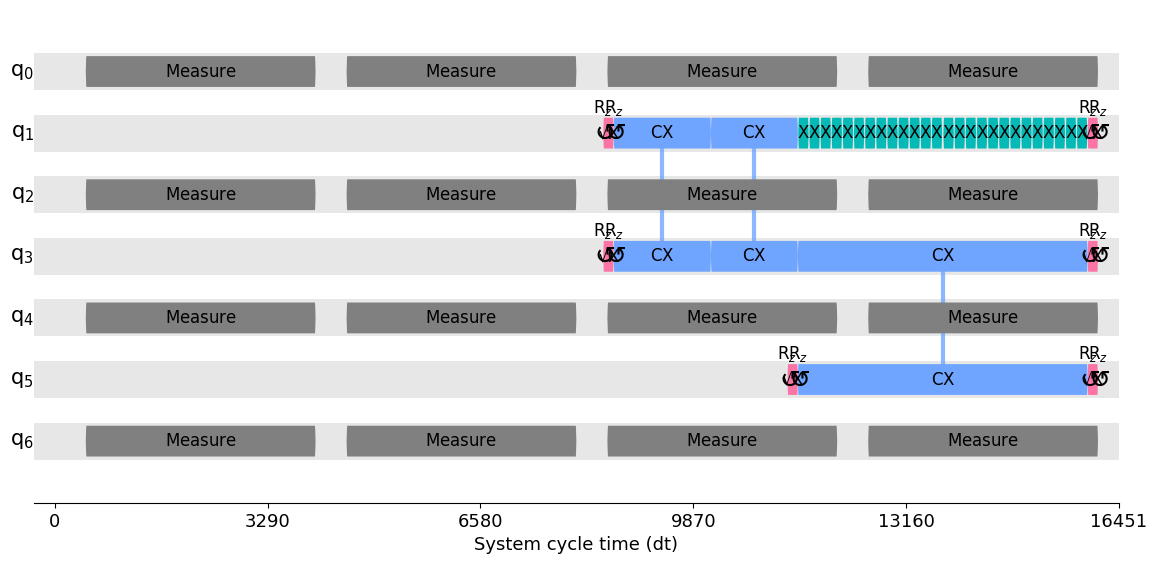

In [14]:
circs = dd_circ_generation(victim_qubs, snooping_qubits)
circ_dd = pm.run(circs[3])
timeline_drawer(circ_dd[1])
# timeline_drawer(circ_dd[1], time_range=(9126, 15210))

In [15]:
global_snoop_jobs['barrier_CNOTs_1_2_3_4'] = defaultdict(list)
circs_final = circ_gen_with_barrier(victim_qubs, snooping_qubits, swap_circ=False)

for num_cnot in [1,2,3,4]:
    circs_to_run = circs_final[num_cnot]*(150//len(circs_final[num_cnot]))
    snoop_job = backend.run(circs_to_run, 
                          meas_level=2,
                          shots=10000)
    print(snoop_job.job_id())
    # job_monitor(snoop_job)
    global_snoop_jobs['barrier_CNOTs_1_2_3_4']['_'.join(map(str, victim_qubs))].append(snoop_job)

cmwtf3mwjay0008cmhrg
cmwtf44d31100080agwg
cmwtf54atcpg0084r8h0
cmwtf5m7xy7g0089rb4g


In [16]:
global_snoop_jobs['barrier_SWAPs_1_2_3_4'] = defaultdict(list)
circs_final = circ_gen_with_barrier(victim_qubs, snooping_qubits, swap_circ=True)

for num_cnot in [1,2,3,4]:
    circs_to_run = circs_final[num_cnot]*(150//len(circs_final[num_cnot]))
    snoop_job = backend.run(circs_to_run, 
                          meas_level=2,
                          shots=10000)
    print(snoop_job.job_id())
    # job_monitor(snoop_job)
    global_snoop_jobs['barrier_SWAPs_1_2_3_4']['_'.join(map(str, victim_qubs))].append(snoop_job)

cmwtf5wd31100080agxg
cmwtf64atcpg0084r8hg
cmwtf6mapzf0008zv9gg
cmwtf6w7xy7g0089rb50


In [17]:
global_snoop_jobs['wo_barrier_CNOTs_1_2_3_4'] = defaultdict(list)
circs_final = circ_gen_without_barrier(victim_qubs, snooping_qubits, swap_circ=False)

for num_cnot in [1,2,3,4]:
    circs_to_run = circs_final[num_cnot]*(150//len(circs_final[num_cnot]))
    snoop_job = backend.run(circs_to_run, 
                          meas_level=2,
                          shots=10000)
    print(snoop_job.job_id())
    # job_monitor(snoop_job)
    global_snoop_jobs['wo_barrier_CNOTs_1_2_3_4']['_'.join(map(str, victim_qubs))].append(snoop_job)

cmwtf7capzf0008zv9h0
cmwtf7m7xy7g0089rb5g
cmwtf85jv9fg00830dbg
cmwtf8nd31100080agy0


In [18]:
global_snoop_jobs['wo_barrier_SWAPs_1_2_3_4'] = defaultdict(list)
circs_final = circ_gen_without_barrier(victim_qubs, snooping_qubits, swap_circ=True)

for num_cnot in [1,2,3,4]:
    circs_to_run = circs_final[num_cnot]*(150//len(circs_final[num_cnot]))
    snoop_job = backend.run(circs_to_run, 
                          meas_level=2,
                          shots=10000)
    print(snoop_job.job_id())
    # job_monitor(snoop_job)
    global_snoop_jobs['wo_barrier_SWAPs_1_2_3_4']['_'.join(map(str, victim_qubs))].append(snoop_job)

cmwtf95wjay0008cmhs0
cmwtf9dapzf0008zv9hg
cmwtf9napzf0008zv9j0
cmwtfa5atcpg0084r8j0


In [19]:
global_snoop_jobs['multi_meas_CNOTs_1_2_3_4'] = defaultdict(list)
circs_final = circ_gen_multiple_meas(victim_qubs, snooping_qubits, swap_circ=False)

for num_cnot in [1,2,3,4]:
    circs_to_run = circs_final[num_cnot]*(150//len(circs_final[num_cnot]))
    snoop_job = backend.run(circs_to_run, 
                          meas_level=2,
                          shots=10000)
    print(snoop_job.job_id())
    # job_monitor(snoop_job)
    global_snoop_jobs['multi_meas_CNOTs_1_2_3_4']['_'.join(map(str, victim_qubs))].append(snoop_job)
    

cmwtfadapzf0008zv9jg
cmwtfand31100080agyg
cmwtfb5apzf0008zv9k0
cmwtfbdwjay0008cmhsg


In [20]:
global_snoop_jobs['multi_meas_SWAPs_1_2_3_4'] = defaultdict(list)
circs_final = circ_gen_multiple_meas(victim_qubs, snooping_qubits, swap_circ=True)

for num_cnot in [1,2,3,4]:
    circs_to_run = circs_final[num_cnot]*(150//len(circs_final[num_cnot]))
    snoop_job = backend.run(circs_to_run, 
                          meas_level=2,
                          shots=10000)
    print(snoop_job.job_id())
    # job_monitor(snoop_job)
    global_snoop_jobs['multi_meas_SWAPs_1_2_3_4']['_'.join(map(str, victim_qubs))].append(snoop_job)

cmwtfbxd31100080agz0
cmwtfcdatcpg0084r8jg
cmwtfcxatcpg0084r8k0
cmwtfd5d31100080agzg


In [21]:
circs_final = dd_circ_generation(victim_qubs, snooping_qubits, swap_circ=False)
circs_to_run = circs_final[1]*(10//len(circs_final[1]))
circ_dd = pm.run(circs_to_run)
snoop_job = backend.run(transpile(circ_dd, backend, scheduling_method="alap", 
                        timing_constraints={'granularity':16, 'acquire_alignment':16}), 
                        meas_level=2, shots=10000)
print(snoop_job.job_id())
# job_monitor(snoop_job)

cmwtfdnjv9fg00830dcg


In [22]:
circs_final = dd_circ_generation(victim_qubs, snooping_qubits, swap_circ=False)
for num_cnot in [1,2,3,4]:
    circs_to_run = circs_final[num_cnot]*(100//len(circs_final[num_cnot]))
    circ_dd = pm.run(circs_to_run)
    snoop_job = backend.run(transpile(circ_dd, backend, scheduling_method="alap", timing_constraints={'granularity':16, 'acquire_alignment':16}), 
                          meas_level=2,
                          shots=10000)
    print(snoop_job.job_id())
    # job_monitor(snoop_job)
    global_snoop_jobs['_'.join(map(str, victim_qubs))].append(snoop_job)

cmwtfe5jv9fg00830dd0
cmwtff57xy7g0089rb60
cmwtffxatcpg0084r8kg
cmwtfgpwjay0008cmht0


In [23]:
global_snoop_jobs['dd_SWAPs_1_2_3_4'] = defaultdict(list)
circs_final = dd_circ_generation(victim_qubs, snooping_qubits, swap_circ=True)
for num_cnot in [1,2,3,4]:
    circs_to_run = circs_final[num_cnot]*(100//len(circs_final[num_cnot]))
    circ_dd = pm.run(circs_to_run)
    snoop_job = backend.run(transpile(circ_dd, backend, scheduling_method="alap", timing_constraints={'granularity':16, 'acquire_alignment':16}), 
                          meas_level=2,
                          shots=10000)
    print(snoop_job.job_id())
    # job_monitor(snoop_job)
    global_snoop_jobs['dd_SWAPs_1_2_3_4']['_'.join(map(str, victim_qubs))].append(snoop_job)

cmwtfhe7xy7g0089rb70
cmwtfj6atcpg0084r8m0
cmwtfk6atcpg0084r8n0
cmwtfkyapzf0008zv9m0
